
# Intro


**Notes**

The main bulk of the material comes from https://developers.google.com/machine-learning/recommendation/overview/candidate-generation. If you want to go further later, you can take a look at http://nicolas-hug.com/blog/matrix_facto_3. It is absolutely not expected to look at these two links for the interviews  or to complete the test.

**Context**: 

We want to build a movies' recommender in order to get new movies to watch during the lock down. We will base our work on a variation of the MovieLens dataset. 
The data consists of movies seen by the users, some informations about the movies, and some informations about the users. The problem consists in predicting which movies a given user might like.

We are presenting you here first a naive approach in order to familarize yourself with the problem and show you how it might be solved.

**Task**:

The code presented is a first implementation but has a number of shortcomings in its structure and features (more on that in the conclusion). Your task consist in producing a refactoring, so as to be one step closer to a "clean" code.

**Evaluation**:

Our goal here is two fold:
- See how you understand a problem and adapt to an already given approach to tackle it.
- See how you can design new features.
- See how you manipulate python code: understanding, ideas to refactor etc ...

The projects will be evaluated on the quality of the source code produced.

# The data

## First, let's load some data.

In [1]:
import pandas as pd

users = pd.read_csv("data/users.csv")
print(users.shape)
users.head()

(6040, 5)


,user_id,gender,age,occupation,zip_code
0,0,F,1,10,48067
1,1,M,56,16,70072
2,2,M,25,15,55117
3,3,M,45,7,02460
4,4,M,25,20,55455


In [2]:
movies = pd.read_csv("data/movies.csv")
print(movies.shape)
movies.head()

(3883, 21)


,movie_id,title,year,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,...,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,0,Toy Story,1995,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Jumanji,1995,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Grumpier Old Men,1995,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Waiting to Exhale,1995,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Father of the Bride Part II,1995,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
ratings = pd.read_csv("data/ratings.csv")
print(ratings.shape) # Over 1M ratings
ratings.head()

(1000209, 3)


,user_id,movie_id,rating
0,0,1176,5
1,0,655,3
2,0,902,3
3,0,3339,4
4,0,2286,5


## EDA :

Before anything else, I think it is important and relevant to do some exploratory data analysis to know what we are working with and to maybe detect some anomalies in the dataset (presence of *NaN* values, negative ratings, no movie genre assigned, etc...)


### Number of occurences for each movie genre :

Text(0, 0.5, 'Occurences of each genres')

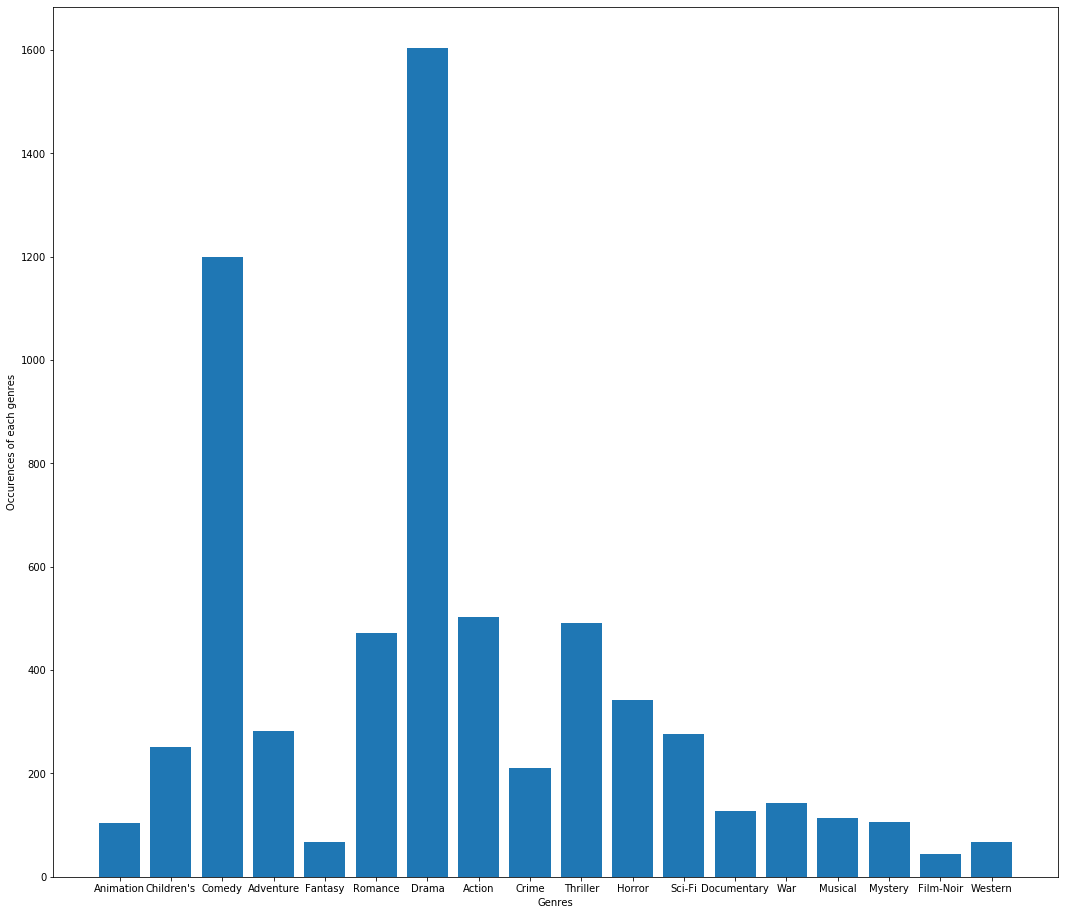

In [4]:
import matplotlib.pyplot as plt
import numpy as np

genre_cols = ["Animation", "Children's", 
       'Comedy', 'Adventure', 'Fantasy', 'Romance', 'Drama',
       'Action', 'Crime', 'Thriller', 'Horror', 'Sci-Fi', 'Documentary', 'War',
       'Musical', 'Mystery', 'Film-Noir', 'Western']

occurences_of_each_genre = movies[genre_cols].sum()

plt.figure(figsize=(18,16))
plt.bar(np.arange(len(occurences_of_each_genre)),occurences_of_each_genre.to_list())
plt.xticks(np.arange(len(occurences_of_each_genre)),genre_cols)
plt.xlabel('Genres')
plt.ylabel('Occurences of each genres')

This bar chart allows us to see the distribution of each movie genre present in the dataset. 
Drama and Comedy are obviously the two most prominent genres in this study.

### Count of occurences for the different number of genres for movies

c:\users\procu\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\procu\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Text(0.5, 0, 'Number of genres for a movie')

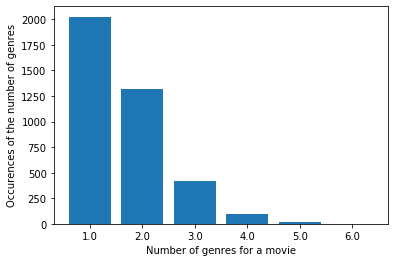

In [5]:
nb_gender_per_movies = movies[genre_cols]
nb_gender_per_movies.loc[:,'count']=movies[genre_cols].sum(axis=1)

nb_gender_set=list(set(nb_gender_per_movies['count']))

counts_nb_gender = list()
for i in nb_gender_set:
    counts_nb_gender.append(nb_gender_per_movies.loc[nb_gender_per_movies['count']==i].shape[0])
    
plt.bar(nb_gender_set,counts_nb_gender)
plt.xticks(nb_gender_set,nb_gender_set)
plt.ylabel('Occurences of the number of genres')
plt.xlabel('Number of genres for a movie')

We can see two relevant informations on this bar chart :

1. No movie has 0 genre assigned, which is good to know for the rest of the study.

2. Most movies are concentrated in the first two bars, which means that a large majority of them is assigned to one or two genres. This will also reveal to be relevant in what's comming next.

We might now want to explore in details the most common movie genre to see how they compose with other genres.

### Drama and comedy genres study

Text(0.5, 0, 'Number of genres for a comedy movie')

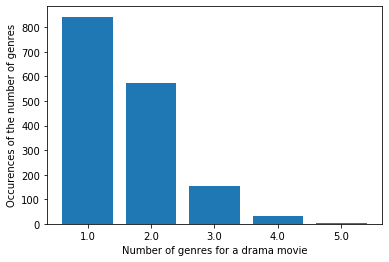

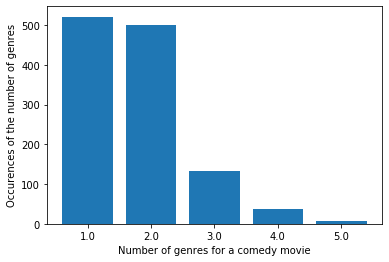

In [6]:
nb_gender_per_drama_movies = movies[genre_cols].loc[nb_gender_per_movies['Drama']==1]
nb_gender_per_drama_movies.loc[:,'count']=movies[genre_cols].loc[nb_gender_per_movies['Drama']==1].sum(axis=1)

nb_gender_per_comedy_movies = movies[genre_cols].loc[nb_gender_per_movies['Comedy']==1]
nb_gender_per_comedy_movies.loc[:,'count']=movies[genre_cols].loc[nb_gender_per_movies['Comedy']==1].sum(axis=1)

nb_gender_drama_set=list(set(nb_gender_per_drama_movies['count']))
nb_gender_comedy_set=list(set(nb_gender_per_comedy_movies['count']))

counts_nb_gender_drama = list()
counts_nb_gender_comedy = list()

for i in nb_gender_drama_set:
    counts_nb_gender_drama.append(nb_gender_per_drama_movies.loc[nb_gender_per_drama_movies['count']==i].shape[0])
    
for i in nb_gender_comedy_set:
    counts_nb_gender_comedy.append(nb_gender_per_comedy_movies.loc[nb_gender_per_comedy_movies['count']==i].shape[0])
    
plt.bar(nb_gender_drama_set,counts_nb_gender_drama)
plt.xticks(nb_gender_drama_set,nb_gender_drama_set)
plt.ylabel('Occurences of the number of genres')
plt.xlabel('Number of genres for a drama movie')

plt.figure(2)
plt.bar(nb_gender_comedy_set,counts_nb_gender_comedy)
plt.xticks(nb_gender_comedy_set,nb_gender_comedy_set)
plt.ylabel('Occurences of the number of genres')
plt.xlabel('Number of genres for a comedy movie')

This informs us that drama and comedy genres follows the general trend of movies: most of them have 1 or 2 genres assigned.
    
### Ratings distribution

Text(0, 0.5, 'Occurences of each rating')

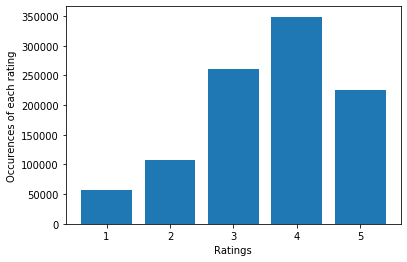

In [7]:
ratings_counts = []
ratings_set = list(set(ratings['rating']))

for i in ratings_set:
    ratings_counts.append(ratings.loc[ratings['rating']==i].shape[0])
    
plt.bar(ratings_set,ratings_counts)
plt.xticks(ratings_set,ratings_set)
plt.xlabel('Ratings')
plt.ylabel('Occurences of each rating')

This chart teaches us two important things :

1. The ratings are discrete and entirely in the {1,2,3,4,5} set (no 0, negative, or NaN rating).
2. Most ratings are concentrated between 3 and 5.

### Dataframe merging for correlation heatmap studies (find relevant features)

Here, we are going to merge the data with the foreign keys included in the dataset (`movie_id` and `user_id`) :


In [8]:
import seaborn as sns


columns = genre_cols+['movie_id','user_id','occupation','zip_code','year','gender','age','rating']
df = movies.merge(ratings,left_on='movie_id',right_on='movie_id').merge(users,left_on='user_id',right_on='user_id')[columns]

df = pd.concat([df,pd.get_dummies(df['gender'],prefix='gender')],axis=1).drop(['gender'],axis=1) # one-hot encode the gender feature
df = pd.concat([df,pd.get_dummies(df['occupation'],prefix='occupation')],axis=1).drop(['occupation'],axis=1) # one-hot encode the occupation feature
corr_pearson = df.corr().loc['rating'].apply(abs)

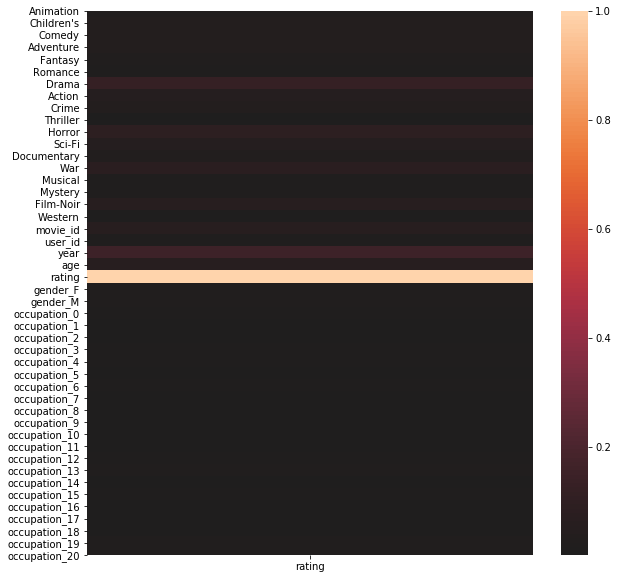

In [9]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(pd.DataFrame(corr_pearson),center=0)

From this heatmap of correlation, we can conclude one main thing : the profile of a user (age, occupation, gender) does not seem to have an effect on their rating. 

Therefore, if we want to include a feature where a user get recommendations based on other similar users, it would have to be more about their tastes in movies rather than their profile. 

### EDA Conclusion

From this exploratory data analysis we learned a few relevant information. 

First, and a very important one, is that all the data is in the expected shape. Every movie has atleast one genre assigned, every rating is between 1 and 5. This will allow us to work on the data without the fear of having to deal with unconform data.

Second, we now know that most movies have 1 or 2 genres assigned, and that is also true for `Drama` and `Comedy` genres which are the most popular. Also, the ratings are mostly comprised of *3,4 and 5* ratings.

Third, in the case of implementation of a recommendation based on similar users, it would not be relevant to use the profile (gender, occupation or age), but rather go for tastes in common.

# Content-based Filtering

Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback. We dont use other users information !

For example, if user `A` liked `Harry Potter 1`, he/she will like `Harry Potter 2`

In [10]:
%%html
<img src='https://miro.medium.com/max/1642/1*BME1JjIlBEAI9BV5pOO5Mg.png' height="300" width="250"/>

What are similar movies ? In order to answer to this question we need to build a similiarity measure. 

## Features

This measure will operate on the characteristics (**features**) of the movies to determine which are close. In our case, we have access to the genres of the movies. For example, the genres of `Toy Story` are: `Animation`, `Children's` and `Comedy`. This is represented as follow in our dataset:

In [11]:
genre_and_title_cols = ['title'] + genre_cols 

movies[genre_and_title_cols].head()

,title,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,Toy Story,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Jumanji,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Grumpier Old Men,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Waiting to Exhale,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Father of the Bride Part II,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Similarity

Now that we have some features, we will try to find a function that performs a similiarity measure. The Similarity function will take two items (two list of features) and return a number proportional to their similarity. 

For the following we will consider that the Similarity between two movies is the number of genres they have in common.

Here is an example with `Toy Story` and `E.T`

In [12]:
toy_story_genres = movies[genre_and_title_cols].loc[movies.title == 'Toy Story'][genre_cols].iloc[0]
toy_story_genres

Animation      1.0
Children's     1.0
Comedy         1.0
Adventure      0.0
Fantasy        0.0
Romance        0.0
Drama          0.0
Action         0.0
Crime          0.0
Thriller       0.0
Horror         0.0
Sci-Fi         0.0
Documentary    0.0
War            0.0
Musical        0.0
Mystery        0.0
Film-Noir      0.0
Western        0.0
Name: 0, dtype: float64

In [13]:
et_genres = movies[genre_and_title_cols].loc[movies.title == 'E.T. the Extra-Terrestrial'][genre_cols].iloc[0]
et_genres

Animation      0.0
Children's     1.0
Comedy         0.0
Adventure      0.0
Fantasy        1.0
Romance        0.0
Drama          1.0
Action         0.0
Crime          0.0
Thriller       0.0
Horror         0.0
Sci-Fi         1.0
Documentary    0.0
War            0.0
Musical        0.0
Mystery        0.0
Film-Noir      0.0
Western        0.0
Name: 1081, dtype: float64

In [14]:
et_genres.values * toy_story_genres

Animation      0.0
Children's     1.0
Comedy         0.0
Adventure      0.0
Fantasy        0.0
Romance        0.0
Drama          0.0
Action         0.0
Crime          0.0
Thriller       0.0
Horror         0.0
Sci-Fi         0.0
Documentary    0.0
War            0.0
Musical        0.0
Mystery        0.0
Film-Noir      0.0
Western        0.0
Name: 0, dtype: float64

In [15]:
(et_genres.values * toy_story_genres).sum()/(toy_story_genres.values.sum()) # scalar product divided by the number of genres of Toy Story

0.3333333333333333

So our similarity measure returns `0.3333333333333333` for these two movies - because one out of three of the genres of Toy Story is shared with E.T (`Children`).

Let's see another example where we compare `Toy Stories` and `Pocahontas`

In [16]:
pocahontas_genres = movies[genre_and_title_cols].loc[movies.title == 'Pocahontas'][genre_cols].iloc[0]
pocahontas_genres

Animation      1.0
Children's     1.0
Comedy         0.0
Adventure      0.0
Fantasy        0.0
Romance        1.0
Drama          0.0
Action         0.0
Crime          0.0
Thriller       0.0
Horror         0.0
Sci-Fi         0.0
Documentary    0.0
War            0.0
Musical        1.0
Mystery        0.0
Film-Noir      0.0
Western        0.0
Name: 47, dtype: float64

In [17]:
(pocahontas_genres.values * toy_story_genres).sum()/(toy_story_genres.values.sum())

0.6666666666666666

This tells us that `Pocahontas` is closer to `Toy Stories` than `E.T.` which makes sense - two out of the three genres of Toy Story is found in Pocahontas (`Animation` and `Children`).

I took the decision of normalizing the similarity between 0 and 1, because this way we have shared boundaries of similarity for every movie.
Top similarity is 1, bottom similarity is 0.

## Scaling up

Ok, that's a nice measure. Now we are going to scale it up to all movies of our dataset. To do so smartly, let's take a look at the operation we just did, but from a mathematical point of view. To do so, we will think of the list of features of a movie as a vector `V`. Then, our similarity measure between `Toy Story` and `E.T.` becomes:
$ V_{ToyStory} \cdot V_{ET}^{T}$

More generally the similarity measure between a movie `i` and another movie `j` is : $ V_{i} \cdot V_{j}^{T}$

Now we can think of `movies` as a matrix containing all features vectors describing the movies. Here is how our similiarity measure looks in this context:

![](imgs/dot_product_matrices.png)

To obtain the similiarity between all movies of our dataset we have to perform the dot product of the `movies` matrix with the transposed of the `movies` matrix.
The `lambda` function allows to divide each row by the sum of the row. This way, the resulting similarity matrix is normalized between 0 and 1.

In [18]:
similarity = pd.DataFrame(data=movies[genre_cols].apply(lambda x : x/sum(x),axis=1).values.dot(movies[genre_cols].values.T),index=movies.loc[:,'movie_id'],columns=movies.loc[:,'movie_id'])
similarity #has to be read through lines : similarity.loc[0,2]!=similarity.loc[2,0]
#it means that movie_id=0 has one of his three genres shared with movie_id=2
#and movie_id=2 has one of his two genres shared with movie_id=0

movie_id,0,1,2,3,4,5,6,7,8,9,...,3873,3874,3875,3876,3877,3878,3879,3880,3881,3882
movie_id,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.333333,0.333333,0.333333,0.333333,0.0,0.333333,0.333333,0.0,0.000000,...,0.333333,0.333333,0.666667,0.0,0.0,0.333333,0.0,0.0,0.0,0.0
1,0.333333,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.666667,0.0,0.333333,...,0.000000,0.000000,0.666667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.500000,0.000000,1.000000,0.500000,0.500000,0.0,1.000000,0.000000,0.0,0.000000,...,0.500000,0.500000,0.000000,0.0,0.0,0.500000,0.0,0.0,0.0,0.0
3,0.500000,0.000000,0.500000,1.000000,0.500000,0.0,0.500000,0.000000,0.0,0.000000,...,0.500000,1.000000,0.000000,0.5,0.0,0.500000,0.5,0.5,0.5,0.5
4,1.000000,0.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.000000,0.0,0.000000,...,1.000000,1.000000,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,1.000000,0.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.000000,0.0,0.000000,...,1.000000,1.000000,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
3879,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,0.000000,1.0,0.0,0.000000,1.0,1.0,1.0,1.0
3880,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,0.000000,1.0,0.0,0.000000,1.0,1.0,1.0,1.0


We can now get the similarity between `Toy Story` and any other movie of our dataset

In [19]:
similarity_with_toy_story = similarity.loc[0,:] # 0 is Toy Story
similarity_with_toy_story

movie_id
0       1.000000
1       0.333333
2       0.333333
3       0.333333
4       0.333333
          ...   
3878    0.333333
3879    0.000000
3880    0.000000
3881    0.000000
3882    0.000000
Name: 0, Length: 3883, dtype: float64

In [20]:
for i in range(10):
    print(f"Similarity between Toy story and {movies.iloc[i]['title']} (index {i}) is {similarity_with_toy_story[i]}")

Similarity between Toy story and Toy Story (index 0) is 1.0
Similarity between Toy story and Jumanji (index 1) is 0.3333333333333333
Similarity between Toy story and Grumpier Old Men (index 2) is 0.3333333333333333
Similarity between Toy story and Waiting to Exhale (index 3) is 0.3333333333333333
Similarity between Toy story and Father of the Bride Part II (index 4) is 0.3333333333333333
Similarity between Toy story and Heat (index 5) is 0.0
Similarity between Toy story and Sabrina (index 6) is 0.3333333333333333
Similarity between Toy story and Tom and Huck (index 7) is 0.3333333333333333
Similarity between Toy story and Sudden Death (index 8) is 0.0
Similarity between Toy story and GoldenEye (index 9) is 0.0


## A bit of polishing

### Helpers:

We also built some helpers to handle the movies dataset:

In [21]:
import importlib
import sys

#so that changes to movies.py is considered in the notebook without restarting the kernel
#importlib.reload(sys.modules['content_based_filtering.helpers.movies']) 
from content_based_filtering.helpers.movies import get_movie_id, get_movie_name, get_movie_year 
    
print (get_movie_id(movies, 'Toy Story'))
print (get_movie_id(movies, 'Die Hard'))

print (get_movie_name(movies, 0))
print (get_movie_name(movies, 1023))
print (get_movie_year(movies, 1000))

0
1023
Toy Story
Die Hard
1961


### Finding similar movies:
Here is a method giving us the movie the most similar to another movie:

In [22]:
def get_most_similar(similarity, movie_name, year=None, top=similarity.shape[0]): 
    #I changed the default top to the similarity's number of rows. To get the similarity with all other movies.
    index_movie = get_movie_id(movies, movie_name, year)
    best = list(similarity.loc[index_movie,:].sort_values(ascending=False).index)
    return [(ind, movies[movies['movie_id']==ind].title.values[0], similarity.loc[index_movie, ind]) for ind in best[:top] if ind != index_movie]

In [23]:
get_most_similar(similarity,'Toy Story')[:10]

[(667, 'Space Jam', 1.0),
 (3685, 'Adventures of Rocky and Bullwinkle, The', 1.0),
 (3682, 'Chicken Run', 1.0),
 (2009, 'Jungle Book, The', 1.0),
 (2011, 'Lady and the Tramp', 1.0),
 (2012, 'Little Mermaid, The', 1.0),
 (2033, 'Steamboat Willie', 1.0),
 (2072, 'American Tail, An', 1.0),
 (2073, 'American Tail: Fievel Goes West, An', 1.0),
 (3542, 'Saludos Amigos', 1.0)]

In [24]:
get_most_similar(similarity, 'Psycho', 1960)[:10]

[(3593, "Puppet Master III: Toulon's Revenge", 1.0),
 (2923, 'Rawhead Rex', 1.0),
 (1312, 'Believers, The', 1.0),
 (3407, "Jacob's Ladder", 1.0),
 (1957, 'Disturbing Behavior', 1.0),
 (1927, 'Poltergeist III', 1.0),
 (1926, 'Poltergeist II: The Other Side', 1.0),
 (1925, 'Poltergeist', 1.0),
 (732, 'Thinner', 1.0),
 (69, 'From Dusk Till Dawn', 1.0)]

### Giving a recommendation:

And finally, let's find some movies to recommend based on previously liked movies:

In [25]:
def MAPE(test,recommendations):
    mape=0
    for index,row in test.iterrows():
        rating = row['rating']
        #scaling the similarity to fit the rating values to compute the error
        scaled_similarity = (recommendations.loc[recommendations['movie_id']==row['movie_id']].loc[:,'similarity'].values*4)+1
        if scaled_similarity<1.5:
            scaled_similarity=1
        elif scaled_similarity<2.5:
            scaled_similarity=2
        elif scaled_similarity<3.5:
            scaled_similarity=3
        elif scaled_similarity<4.5:
            scaled_similarity=4
        else:
            scaled_similarity=5
        #rounding scaled_similarity to fit the discreteness of rating
            
        #print("Index:",str(index)," | Rating",rating," | Computed Similarity: ",str(recommendations.loc[recommendations['movie_id']==row['movie_id']].loc[:,'similarity'].values)," | Scaled Similarity",str(scaled_similarity))
        mape+=abs(rating-scaled_similarity)/rating
        
    return mape/test.shape[0]

In [26]:
def get_recommendations(user_id,nb_top_movies=3,nb_movies_return=5):
    
    train=ratings[ratings['user_id']==user_id].sample(frac=0.7).reset_index(drop=True)
    test=pd.concat([ratings[ratings['user_id']==user_id],train]).drop_duplicates(keep=False)
    #Introducing a train and test split to evaluate the recommendation system (70%-30%)
    
    top_movies = train[train['user_id'] == user_id].sort_values(by='rating', ascending=False).head(nb_top_movies).loc[:,'movie_id']
    index=['movie_id', 'title', 'similarity']

    most_similars = []
    for top_movie in top_movies:
        most_similars += get_most_similar(similarity, get_movie_name(movies, top_movie), get_movie_year(movies, top_movie))

    res = pd.DataFrame(most_similars, columns=index).groupby('movie_id',as_index=False).max().sort_values(by='similarity', ascending=False).reset_index(drop=True) 
    # I changed the drop_duplicates to a groupby to remove the duplicates, but keeping the maximum between the duplicates
    
    #for index,row in test.iterrows():
       #print(f"Movie id: {row['movie_id']}, Rated: {row['rating']}, Computed Similarity: {res.loc[res['movie_id']==row['movie_id']][:,'similarity'].values}")
    print('MAPE : ',MAPE(test,res)*100,'%')    
    return res.head(nb_movies_return)

In [27]:
get_recommendations(user_id=0,nb_top_movies=10)

MAPE :  21.875 %


,movie_id,title,similarity
0,0,Toy Story,1.0
1,1819,Hope Floats,1.0
2,2033,Steamboat Willie,1.0
3,2035,Tex,1.0
4,2037,Swing Kids,1.0


In [28]:
test_recommendation=get_recommendations(user_id=150,nb_top_movies=10)
test_recommendation

MAPE :  57.4822695035461 %


,movie_id,title,similarity
0,0,Toy Story,1.0
1,3105,Man on the Moon,1.0
2,3093,Simpatico,1.0
3,1899,"Breakfast Club, The",1.0
4,2531,eXistenZ,1.0


With the testing system implemented, we could develop an error function to determine the quality of the prediction.
I chose the MAPE function (mean absolute percentage error), because this is a function that describes well the average error relatively to the actual rating. This function takes into account the difference between forecast and actual and its importance when compared to the magnitude of the rating. 

# User-based recommendation

In this section, we will develop a recommendation system based on what movies similar users liked.

We will use the previously created `df` dataframe in the EDA section that is the combination of the 3 data-sets.

In [29]:
def GetTopMovies(user_id,dataframe,nb_top_movies=None):
    if (nb_top_movies):
        return dataframe.loc[df['user_id']==user_id].sort_values(by='rating',ascending=False).loc[:,['movie_id','rating']].head(nb_top_movies)
    else:
        max_rating=max(dataframe.loc[dataframe['user_id']==user_id].loc[:,'rating'])
        return dataframe.loc[(df['user_id']==user_id)&(df['rating']==max_rating)].loc[:,['movie_id','rating']]

GetTopMovies(0,df)

,movie_id,rating
0,0,5
1,47,5
2,148,5
4,523,5
8,591,5
17,1009,5
18,1015,5
19,1016,5
20,1022,5
22,1176,5


In [30]:
def FindSimilarUsers(user_id,dataframe,nb_top_movies):
    top_movies=GetTopMovies(user_id,dataframe,nb_top_movies)
    users=dataframe.loc[(dataframe['movie_id']==top_movies.iloc[0].loc['movie_id']) & (dataframe['rating']==top_movies.iloc[0].loc['rating']) & (dataframe['user_id']!=user_id) ].loc[:,'user_id']
    for index,row in top_movies.iterrows():
        curr_users = dataframe.loc[(dataframe['movie_id']==row.loc['movie_id'])&(dataframe['rating']==row.loc['rating'])].loc[:,'user_id']
        users = pd.Series(list(set(curr_users).intersection(set(users))))#returns the values in common between curr_users and users
    
    if(len(users)==0):
        raise Exception("No similar users. Try lowering the number of top movies to find the similar users.")
    return users
        
FindSimilarUsers(0,df,6)

0    5794
dtype: int64

In [31]:
def UserSimilarityRecommendation(user_id,dataframe,nb_recommendation=None,nb_top_movies=5):
    top_similar_users = FindSimilarUsers(user_id,dataframe,nb_top_movies)
    watched_movies=dataframe.loc[dataframe['user_id']==user_id].loc[:,'movie_id']
    max_rating=max(dataframe.loc[dataframe['user_id']==top_similar_users[0]].loc[:,'rating'])
    top_movies=dataframe.loc[(dataframe['user_id']==top_similar_users[0])&(~dataframe['movie_id'].isin(watched_movies))&(dataframe['rating']==max_rating)].loc[:,'movie_id']
    if(len(top_similar_users)!=1):
        for i in range(1,len(top_similar_users)):
            max_rating=max(dataframe.loc[dataframe['user_id']==top_similar_users[i]].loc[:,'rating'])
            curr_top_movies=dataframe.loc[(dataframe['user_id']==top_similar_users[i])&(~dataframe['movie_id'].isin(watched_movies))&(dataframe['rating']==max_rating)].loc[:,'movie_id']
            top_movies=pd.Series(list(set(curr_top_movies).intersection(set(top_movies))))
    if(nb_recommendation):
        if(len(top_movies)<nb_recommendation):
            return top_movies
        else:
            return top_movies[:nb_recommendation]
    else:
        return top_movies
    
user_based_recomm=UserSimilarityRecommendation(0,df,nb_top_movies=6)
user_based_recomm

555568      13
555570      15
555571      16
555577      24
555581      35
          ... 
556806    3474
556809    3477
556811    3482
556832    3651
556834    3714
Name: movie_id, Length: 287, dtype: int64

This is the list of movie_id recommended to the user `user_id=0` based on the similar users.
The similar users were chosen by giving the same rating to the `nb_top_movies=6` rated by the target user.
The function then searches for the movies not watched by the targeted user and that were given the highest rating by the similar users.

Let's implement an error function to determine the accuracy of the recommendations.
For that, we will simply change the condition that asks for the movie to not have been watched by the targeted user, and make it so that the movie must have been watched and top rated by the targeted user. We will then compare it to the list of the targeted user's top movies.

In [32]:
def UserSimilarityRecommendation_evaluation(user_id,dataframe,nb_recommendation=None,nb_top_movies=5):
    top_similar_users = FindSimilarUsers(user_id,dataframe,nb_top_movies)
    #print(top_similar_users)
    top_watched_movies=GetTopMovies(user_id,dataframe).loc[:,'movie_id']
    max_rating=max(dataframe.loc[dataframe['user_id']==top_similar_users[0]].loc[:,'rating'])
    top_movies=dataframe.loc[(dataframe['user_id']==top_similar_users[0])&(dataframe['rating']==max_rating)&(dataframe['movie_id'].isin(top_watched_movies))].loc[:,'movie_id']
    if(len(top_similar_users)!=1):
        for i in range(1,len(top_similar_users)):
            max_rating=max(dataframe.loc[dataframe['user_id']==top_similar_users[i]].loc[:,'rating'])
            curr_top_movies=dataframe.loc[(dataframe['user_id']==top_similar_users[i])&(dataframe['rating']==max_rating)&(dataframe['movie_id'].isin(top_watched_movies))].loc[:,'movie_id']
            top_movies=pd.Series(list(set(curr_top_movies).intersection(set(top_movies))))
    if(nb_recommendation):
        if(len(top_movies)<nb_recommendation):
            return top_movies
        else:
            return top_movies[:nb_recommendation]
    else:
        return top_movies

user_based_recomm_eval=UserSimilarityRecommendation_evaluation(0,df,nb_top_movies=6)
user_based_recomm_eval

555558       0
555780     523
555812     591
555927    1009
555932    1015
555933    1016
555938    1022
555984    1176
556031    1250
556283    1959
556402    2286
556570    2735
556675    3036
Name: movie_id, dtype: int64

So this list is the list of movies that would be recommended by the similar-users-based recommendation system, and that has been top rated by the targeted user.
Let's now compare it with the list of the top movies watched by the targeted user and get a proportion out of it.

In [33]:
top_movies=GetTopMovies(0,df)
top_movies

,movie_id,rating
0,0,5
1,47,5
2,148,5
4,523,5
8,591,5
17,1009,5
18,1015,5
19,1016,5
20,1022,5
22,1176,5


We can see that every one of the recommended movies are in the top movies of `user_id=0`.
This is a mark of quality in the recommendation system, but we cannot do the MAPE error function as before. We have to do a proportion instead.

In [34]:
(len(user_based_recomm_eval)/len(top_movies))*100

72.22222222222221

It means that out of the top movies watched by `user_id=0`, *72.22%* would have been recommended by the similar-users-based recommendation system.

It is not an error function, but we can deduce that because *72.22%* would have been recommended by the similar-users-based recommendation system, it means that *27.78*% of the top movies would not have been recommended. We can assume that it is our error evaluation in this user-based recommendation system.

Comparing the movie-similarity-based recommendation system to the similar-users-based recommendation system seems to be impossible, as they don't have the same way to function. All of the predictions of the similar-users-based recommendation system are movies that the targeted user would love, but there are a good part of them that are missed. These two recommendation system do not have the same purpose.

Let's look at `user_id=150` now:

In [35]:
len(UserSimilarityRecommendation_evaluation(150,df,nb_top_movies=5))/len(GetTopMovies(150,df))*100

33.663366336633665

For `user_id=150` around one out of three of the loved movie for the user would have been recommended by this system, which is not a really good accuracy.


# Year-based recommendation system

As we saw in the EDA, the year feature seems to have a high correlation with the rating target variable. In this section, we will try to exploit this correlation to build a year-based recommendation system.


In [36]:
def AverageRatingByYear(df,user_id):
    specific_df = df.loc[df['user_id']==user_id].loc[:,['year','rating']]
    counts = specific_df.groupby(by='year',as_index=False).count()
    averages = specific_df.groupby(by='year',as_index=False).mean()
    specific_df= counts.merge(averages,on='year')
    specific_df.columns=['year','count','avg_rating']
    return specific_df.sort_values(by=['avg_rating','count'],ascending=False)

AverageRatingByYear(df,0)

,year,count,avg_rating
2,1941,1,5.000
5,1950,1,5.000
7,1959,1,5.000
10,1965,1,5.000
11,1975,1,5.000
15,1983,1,5.000
16,1985,1,5.000
21,1990,1,5.000
22,1991,1,5.000
25,1995,4,4.500


By seeing this dataframe, we can ask ourselves if it's only the average rating that matters. For example, if the average rating is of 5, then we might think that the user loves movies that got out this year. But when we check the number of movies he rated for that given year, we realise that it's only 1.

So the year might be a bad indication in this case, and we would want to give more importance to the count parameter in the recommendation system we are building.

In [37]:
def GetYearScores(df,user_id,nb_diff_scores=None):
    
    avg_ratings=AverageRatingByYear(df,user_id)
    
    avg_ratings.loc[:,'normalized_avg_rating']=avg_ratings.loc[:,'avg_rating']-min(avg_ratings.loc[:,'avg_rating']) # normalizing to compute score
    avg_ratings.loc[:,'normalized_avg_rating']=avg_ratings.loc[:,'normalized_avg_rating']/max(avg_ratings.loc[:,'normalized_avg_rating'])
    
    avg_ratings.loc[:,'normalized_count']=avg_ratings.loc[:,'count']-min(avg_ratings.loc[:,'count'])# normalizing to compute score
    avg_ratings.loc[:,'normalized_count']=avg_ratings.loc[:,'normalized_count']/max(avg_ratings.loc[:,'normalized_count'])
    
    avg_ratings.loc[:,'score']=(avg_ratings.loc[:,'normalized_avg_rating']*2)+(avg_ratings.loc[:,'normalized_count'])#formula for the score
    
    avg_ratings.loc[:,'score']=avg_ratings.loc[:,'score']-min(avg_ratings.loc[:,'score'])# normalizing score
    avg_ratings.loc[:,'score']=avg_ratings.loc[:,'score']/max(avg_ratings.loc[:,'score'])
    
    avg_ratings = avg_ratings.sort_values(by='score',ascending=False)
    if nb_diff_scores:
        unique_scores=avg_ratings.loc[:,'score'].unique()
        if(nb_diff_scores<len(unique_scores)):         
            avg_ratings = avg_ratings.loc[avg_ratings['score'].isin(unique_scores[:nb_diff_scores])]   
    return avg_ratings

GetYearScores(df,0,3)

,year,count,avg_rating,normalized_avg_rating,normalized_count,score
28,1998,8,4.125,0.5625,1.000000,1.000000
2,1941,1,5.000,1.0000,0.000000,0.941176
5,1950,1,5.000,1.0000,0.000000,0.941176
7,1959,1,5.000,1.0000,0.000000,0.941176
10,1965,1,5.000,1.0000,0.000000,0.941176
11,1975,1,5.000,1.0000,0.000000,0.941176
15,1983,1,5.000,1.0000,0.000000,0.941176
16,1985,1,5.000,1.0000,0.000000,0.941176
21,1990,1,5.000,1.0000,0.000000,0.941176
22,1991,1,5.000,1.0000,0.000000,0.941176


In [38]:
def ScalingScore(x): #to scale the score from the [0,1] interval to the {1,2,3,4,5} rating set
    x=(x*4)+1
    if x<1.5:
        x=1
    elif x<2.5:
        x=2
    elif x<3.5:
        x=3
    elif x<4.5:
        x=4
    else:
        x=5
    return x

def GetYearBasedRecommendations(df,user_id,nb_diff_score=None):
    year_scores=GetYearScores(df,user_id,nb_diff_score).loc[:,['year','score']]
    df = df.merge(year_scores,on='year')
    movies_watched = df.loc[df['user_id']==user_id].loc[:,'movie_id']
    recommendations = df.loc[(~df['movie_id'].isin(movies_watched))].loc[:,['movie_id','year','score']].sort_values(by='score',ascending=False).drop_duplicates()
    recommendations.loc[:,'score']=recommendations.loc[:,'score'].apply(ScalingScore)
    return recommendations

year_based_recomm=GetYearBasedRecommendations(df,0,4)
year_based_recomm

,movie_id,year,score
220116,1849,1998,5
226765,1814,1998,5
226766,1815,1998,5
226767,1816,1998,5
226768,1827,1998,5
...,...,...,...
257882,3848,1988,4
260078,2177,1988,4
259561,2958,1988,4
263684,140,1988,4


In [39]:
def GetYearBasedRecommendations_evaluation(df,user_id,nb_diff_score=None):
    year_scores=GetYearScores(df,user_id,nb_diff_score).loc[:,['year','score']]
    df = df.merge(year_scores,on='year')
    movies_watched = df.loc[df['user_id']==user_id].loc[:,'movie_id']
    recommendations = df.loc[(df['movie_id'].isin(movies_watched))&(df['user_id']==user_id)].loc[:,['movie_id','year','score']].sort_values(by='score',ascending=False)
    recommendations.loc[:,'score']=recommendations.loc[:,'score'].apply(ScalingScore)
    return recommendations

year_based_recomm_eval=GetYearBasedRecommendations_evaluation(df,0,3)
year_based_recomm_eval

,movie_id,year,score
133223,1768,1998,5
133230,2623,1998,5
133229,2286,1998,5
133228,2271,1998,5
133227,2252,1998,5
133226,2225,1998,5
133225,1959,1998,5
133224,1838,1998,5
128414,1267,1959,5
201449,2735,1983,5


In [40]:
def MAPE_YearBased(df,user_id):
    mape=0
    year_based_recomm_eval=GetYearBasedRecommendations_evaluation(df,user_id,3)
    for movie_id in year_based_recomm_eval.loc[:,'movie_id']:
        actual_rating=df.loc[(df['movie_id']==movie_id)&(df['user_id']==user_id)].loc[:,'rating'].values[0]
        forecasted_rating=year_based_recomm_eval.loc[year_based_recomm_eval['movie_id']==movie_id].loc[:,'score'].values[0]
        mape+=abs(actual_rating-forecasted_rating)/actual_rating

    mape/=year_based_recomm_eval.shape[0]
    return mape

print('MAPE for user_id=0: ',str(MAPE_YearBased(df,0)*100),'%')
print('MAPE for user_id=150: ',str(MAPE_YearBased(df,150)*100),'%')

MAPE for user_id=0:  13.095238095238093 %
MAPE for user_id=150:  18.333333333333336 %


The year-based recommendation system seems to have satisfying results. As the EDA indicated (through Pearson's correlation coefficient heatmap), the year feature seems to have a big importance in the likeliness of a user to appreciate a movie.

The results are better for both `user_id=0` and `user_id=150`.

# Conclusion:

After implementing a fix for the indexing of file **movie.csv** that resulted in mismatches in the first part of the project (movie genres similarity recommendation system), I added a feature to this recommendation system by removing the reciprocity (movie A being similar to movie B does *not* mean that movie B is similar to movie A), and by scaling and normalizing the similarity score to compare it to the actual rating given by the user through a train/test split of the dataset, so that we could have an evaluation method (MAPE) and quantify the errors of the recommendation system.

After that, I looked towards implementing a different recommendation system, based on user similarity. I chose to not go on the way of working with the profile of a user (`occupation`,`gender`,`zip_code`,`age`) because the EDA indicated that these features have little to no impact on the target rating variable. Instead, I chose to build a recommendation around the movies that have not been watched by the targeted users, but were rated the maximum by users with very similar tastes to the targeted user. It got great results, as there is basically no error indicated (all the movies recommended by the system were in the top movies of the targeted user) - but rather a problem of movies that were missed, and not recommended, despite being in the top movies of the targeted user.

Finally, once again following the advice of the heatmap produced in the EDA, I implemented a year-based recommendation system (as this parameter had a rather high correlation with the rating). I looked for different scoring functions, based on the average rating per year and the number of movies rated for a year by the targeted user. The scoring function is entirely naive, as using machine learning was not the goal here. Implementing a linear or polynomial regression to find the best scoring function might be a great idea to improve this scoring function. 
In the end, the results are nevertheless better than the original genres-based recommendation system on the two users tested along this project.

As leads to make a better recommendation system, we might think of using machine learning or even neural networks, as I believe this would be a great use-case for them, but it was not the goal here.